# Display Examples

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
import numpy as np
import os
from keras.models import load_model

from keras.backend.tensorflow_backend import set_session
from utils import *

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))


Using TensorFlow backend.


In [2]:
print("Chest X-ray / cxr\n")
base_dir = '/projects/steinbac/adversarial_medical_imaging/cxr/'
model = load_model(f'{base_dir}/wb_model.h5')
#model.summary()

Chest X-ray / cxr

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:

(X_test, cxr_y_test,
 X_test_pgd_wb, X_test_pgd_bb) = getResults(base_dir)

Truth: [[1. 0.]]
Model predict on true image: [[0.9975188  0.00248129]]
Model predict on adversarial image: [[2.3234296e-11 1.0000000e+00]]
Model predict on BB adversarial image: [[0.02201507 0.9779849 ]]

True Image Deprocessed:


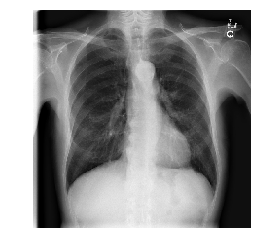

Adversarial Image Deprocessed:


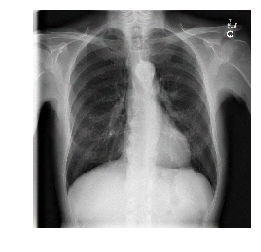

Perturbation*20:


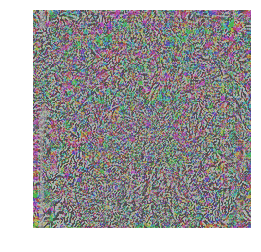

Truth: [[0. 1.]]
Model predict on true image: [[0.20693658 0.79306346]]
Model predict on adversarial image: [[1.0000000e+00 1.0546123e-11]]
Model predict on BB adversarial image: [[0.9799586  0.02004148]]

True Image Deprocessed:


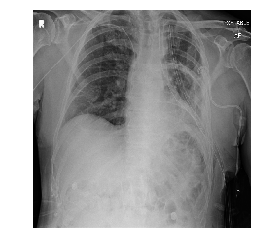

Adversarial Image Deprocessed:


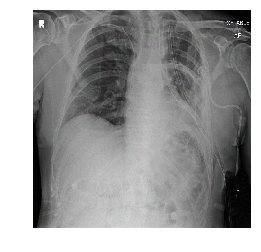

Perturbation*20:


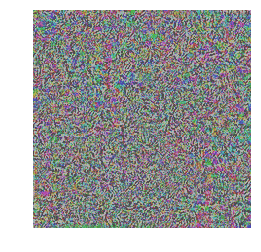

In [4]:
display_adv_examples(2, X_test_pgd_wb, model, X_test, cxr_y_test, verbose = True, X_test_bb = X_test_pgd_bb)
display_adv_examples(8378, X_test_pgd_wb, model, X_test, cxr_y_test, verbose = True, X_test_bb = X_test_pgd_bb)

In [5]:

import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability, Misclassification

fmodel = KerasModel(model, bounds=(-1., 1.))

# run the attack
#attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(1, p=.7))
#attack  = foolbox.attacks.FGSM(fmodel)
#attack = foolbox.attacks.SaltAndPepperNoiseAttack(model=fmodel, criterion=TargetClassProbability(1, p=.5))

attack = foolbox.attacks.LBFGSAttack(model=fmodel, criterion=TargetClassProbability(1, p=.7))
image = np.asarray(X_test[1:2,...])
print(f"image of {image.shape} loaded")

kpred = model.predict(image)
print(f"model.predict labels of {np.argmax(kpred)} ({kpred}, {kpred.shape})")

pred  = fmodel.predictions(image[0])
label = np.argmax(pred)
print(f"fmodel.predictions labels of {label} {label.shape} ({pred}, {pred.shape})")


image of (1, 224, 224, 3) loaded
model.predict labels of 0 ([[0.99802065 0.00197934]], (1, 2))
fmodel.predictions labels of 0 () ([ 3.9993238 -2.223685 ], (2,))


1 0
True Image Deprocessed:


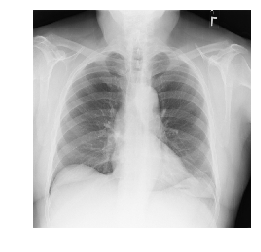

Adversarial Image Deprocessed:


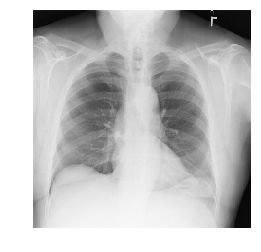

Perturbation*20:


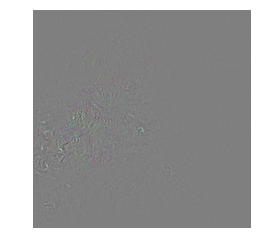

(array([     6,     37,    314,   7417, 140950,   1607,    160,     26,
            6,      5]), array([-0.01929607, -0.01479975, -0.01030342, -0.00580709, -0.00131077,
        0.00318556,  0.00768189,  0.01217821,  0.01667454,  0.02117086,
        0.02566719], dtype=float32))


In [6]:
adversarial = attack( image[0] , label)                 
if not isinstance(adversarial, type(None)):
    print(np.argmax(fmodel.predictions(adversarial)), label)

plot_to_compare(image[0], adversarial)

In [7]:
attack6 = foolbox.attacks.ContrastReductionAttack(model=fmodel, criterion=Misclassification() )
adversarial6 = attack6( image[0] , label)
if not isinstance(adversarial6, type(None)):
    print(np.argmax(fmodel.predictions(adversarial6)), label)
    plot_to_compare(image[0], adversarial6)
else:
    print('attack6 didn\'t find an adversarial example')

attack6 didn't find an adversarial example


/projects/steinbac/software/foolbox/repo/foolbox/attacks/base.py:148: UserWarning: ContrastReductionAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [8]:
attack2 = foolbox.attacks.SaltAndPepperNoiseAttack(model=fmodel, criterion=Misclassification())
adversarial2 = attack2( image[0] , label)
if not isinstance(adversarial2, type(None)):
    print(np.argmax(fmodel.predictions(adversarial2)), label)
    plot_to_compare(image[0], adversarial2)
else:
    print('attack2 didn\'t find an adversarial example')

attack2 didn't find an adversarial example


/projects/steinbac/software/foolbox/repo/foolbox/attacks/base.py:148: UserWarning: SaltAndPepperNoiseAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [9]:
attack3 = foolbox.attacks.GaussianBlurAttack(model=fmodel, criterion=Misclassification())
adversarial3 = attack3( image[0] , label)
if not isinstance(adversarial3, type(None)):
    print(np.argmax(fmodel.predictions(adversarial3)), label)
    plot_to_compare(image[0], adversarial3)
else:
    print('attack3 didn\'t find an adversarial example')

attack3 didn't find an adversarial example


/projects/steinbac/software/foolbox/repo/foolbox/attacks/base.py:148: UserWarning: GaussianBlurAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [10]:
attack4 = foolbox.attacks.AdditiveUniformNoiseAttack(model=fmodel, criterion=Misclassification())
adversarial4 = attack4( image[0] , label)
if not isinstance(adversarial4, type(None)):
    print(np.argmax(fmodel.predictions(adversarial4)), label)
    plot_to_compare(image[0], adversarial4)
else:
    print('attack4 didn\'t find an adversarial example')

attack4 didn't find an adversarial example


/projects/steinbac/software/foolbox/repo/foolbox/attacks/base.py:148: UserWarning: AdditiveUniformNoiseAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [11]:
attack5 = foolbox.attacks.LocalSearchAttack(model=fmodel, criterion=Misclassification())
adversarial5 = attack5( image[0] , label)
if not isinstance(adversarial5, type(None)):
    print(np.argmax(fmodel.predictions(adversarial5)), label)
    plot_to_compare(image[0], adversarial5)
else:
    print('attack5 didn\'t find an adversarial example')

attack5 didn't find an adversarial example


/projects/steinbac/software/foolbox/repo/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [12]:
attack6 = foolbox.attacks.ContrastReductionAttack(model=fmodel, criterion=Misclassification() )
adversarial6 = attack6( image[0] , label)
if not isinstance(adversarial6, type(None)):
    print(np.argmax(fmodel.predictions(adversarial6)), label)
    plot_to_compare(image[0], adversarial6)
else:
    print('attack6 didn\'t find an adversarial example')

attack6 didn't find an adversarial example


In [6]:
#let's find an adversarial example for class label 0
images = np.asarray(X_test[7000:,...])
preds  = model.predict(images)

In [7]:
print(preds.shape)
labels = np.zeros(shape=(preds.shape[0],))-1
for entry in range(preds.shape[0]):
    assert preds[entry,:].shape == (2,) 
    labels[entry] = np.argmax(preds[entry,:])

print(np.histogram(labels))
class0 = labels == 0
class1 = labels == 1

X_test_c1_indices = class1.nonzero()[0] + 7000
X_test_c0_indices = class0.nonzero()[0] + 7000
print(X_test_c0_indices)
print(X_test_c1_indices)

(1383, 2)
(array([1038,    0,    0,    0,    0,    0,    0,    0,    0,  345]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
[7000 7001 7002 ... 8372 8373 8374]
[7070 7071 7072 7173 7394 7684 7687 7691 7692 7694 7695 7696 7697 7698
 7699 7700 7701 7702 7703 7704 7705 7706 7707 7708 7709 7710 7711 7712
 7713 7714 7715 7716 7717 7718 7720 7721 7722 7723 7724 7725 7726 7727
 7728 7733 7735 7745 7747 7753 7762 7763 7764 7765 7766 7769 7772 7773
 7775 7779 7793 7794 7806 7811 7815 7831 7832 7833 7834 7835 7836 7837
 7838 7839 7840 7841 7842 7858 7859 7860 7861 7866 7867 7868 7869 7870
 7871 7872 7873 7874 7875 7876 7877 7880 7881 7886 7887 7897 7899 7900
 7903 7904 7905 7906 7907 7908 7910 7911 7912 7913 7931 7932 7933 7934
 7935 7936 7938 7939 7940 7941 7942 7945 7946 7949 7950 7951 7952 7953
 7956 7957 7959 7960 7961 7963 7964 7970 7976 7977 7978 7979 7980 7981
 7984 7986 7988 7991 7992 7993 7998 7999 8009 8010 8021 8022 8023 8031
 8032 8034 8039 8040 8041 8045 8046 804

run with verbose=True to see details
Step 0: 1.30317e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 2500: 2.77774e-05, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (3.2544e-08) (took 0.05911 seconds)
Step 5000: 8.34024e-06, stepsizes = 1.5e-02/1.7e-04: d. reduced by 0.03% (2.8935e-09) (took 0.08723 seconds)
1 0
True Image Deprocessed:


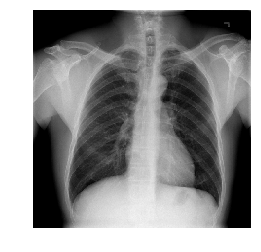

Adversarial Image Deprocessed:


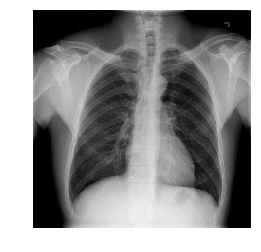

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Perturbation*20:


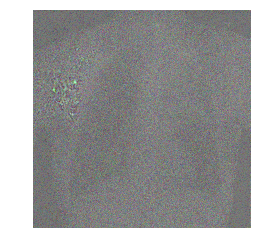

(array([   18,  1421, 31116, 86022, 30198,  1703,    39,     6,     3,
           2]), array([-0.0316951 , -0.02305659, -0.01441809, -0.00577959,  0.00285892,
        0.01149742,  0.02013593,  0.02877443,  0.03741293,  0.04605144,
        0.05468994], dtype=float32))
run with verbose=True to see details
Step 0: 1.22009e-01, stepsizes = 1.0e-02/1.0e-02: 


In [ ]:
boundattack = foolbox.attacks.BoundaryAttack(model=fmodel, criterion=Misclassification() )
img_idx = X_test_c0_indices[0]
image = X_test[img_idx]
label = 0
    
for adv_idx in X_test_c1_indices[:20]:
    adv_start = X_test[adv_idx]
    bound_adv   = boundattack( image, label, starting_point=adv_start, log_every_n_steps=2500)
    if not isinstance(bound_adv, type(None)):
        print(np.argmax(fmodel.predictions(bound_adv)), label)
        plot_to_compare(image, bound_adv,adv_start)
        
    else:
        print(f'{boundattack.name()} didn\'t find an adversarial example for validation image {adv_idx}')

# Toy Model Confidence Plots

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def confidence_plot(preds = [0.93706179, 0.06293821],
                  labels = ["Pneumothorax", "Normal"],
                   isNormal = True, hideText = False,
                   diseaseTop = False):
    sns.set(font_scale=2)

    if isNormal:
        pal = ["red", "green"]
    else:
        pal = ["green", "red"]
        
    if not diseaseTop:
        preds.reverse()
        pal.reverse()
        labels.reverse()
        
    d = {'Model Confidence' : pd.Series(preds, index=['a', 'b']),
         'Diagnosis' : pd.Series(labels, index=['a', 'b'])}
    ax = sns.barplot(x="Model Confidence", y="Diagnosis",
                     data=pd.DataFrame(d), palette=pal)
    ax.set_xlim((0,1))
    ax.set_ylabel('') 
    if hideText:
        ax.set_yticklabels(['',''])
        ax.set_xlabel('')
        ax.set_xticklabels('')
    plt.show()

### Generate plots

In [ ]:
hide_diag = False
confidence_plot([ 0.00930259, 0.9906974],
               ["Malignant", "Benign"],
               isNormal = True, hideText = hide_diag)

confidence_plot([1.0000000e+00, 2.2059932e-11],
               ["Malignant", "Benign"],
               isNormal = True, hideText = hide_diag)

In [ ]:
hide_diag = False
confidence_plot([ 0.048, 1 - 0.048],
               ["Diabetic \nRetinopathy", "Healthy"],
               isNormal = True, hideText = hide_diag)

confidence_plot([1.0000000e+00, 2.2059932e-11],
               ["Diabetic \nRetinopathy", "Healthy"],
               isNormal = True, hideText = hide_diag)

# ROC, Sensitivity, Specificity

## Load Model Output

In [ ]:
import numpy as np
import os
os.chdir('/home/sgf2/DBMI_server/adversarial_attacks/')

y_test_dr = np.load('retinopathy/data/val_test_y.npy')
preds_dr = np.load('retinopathy/data/winning_model_preds.npy') #from model 30 epochs is best right now
print((preds_dr.shape, y_test_dr.shape))

y_test_cxr = np.load('cxr/data/val_test_y.npy')
preds_cxr = np.load('cxr/data/winning_model_preds.npy')
print((y_test_cxr.shape, preds_cxr.shape))

y_test_derm = np.load('melanoma/data/val_test_y.npy')
preds_derm = np.load('melanoma/data/winning_model_preds.npy')
print((preds_derm.shape, y_test_derm.shape))

## Plot Roc

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Generate roc curves from lists of: predictions, labels, and titles
def plot_roc(preds_list, y_test_list ,
             curve_titles_list = None,
             mainTitle = 'Receiver operating characteristic curve'):
    
    # If input is not list, convert it to a list
    if type(preds_list) is not list:
        preds_list = [preds_list]
        y_test_list = [y_test_list]
        if curve_titles_list is not None:
            curve_titles_list = [curve_titles_list]
        
    assert len(preds_list) == len(y_test_list), "Must provide same number of preds and labels."
    
    # Set up figure of size 5x5
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
        
    # Cycle through lists of predictions and labels and generate roc curves
    for preds, y_test, curve_title in zip(preds_list, y_test_list, curve_titles_list):
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,1], preds[:,1])
        auc_score = auc(fpr,tpr)
        curve_label = curve_title + ' (AUC=%0.2f)' % float(auc_score)
        if len(preds_list) == 1:
            plt.plot(fpr,tpr,label= curve_label, color="darkorange")
        else:
            plt.plot(fpr,tpr,label= curve_label)
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   
    # Set axes and titles
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(mainTitle)
    plt.legend(loc="lower right")
    
    # Display
    plt.show()

plot_roc([preds_dr, preds_cxr, preds_derm],
         [y_test_dr, y_test_cxr, y_test_derm],
         ['Retinopathy', 'Pneumothorax', 'Melanoma'],
         "Performance of baseline diagnostic models")

#plot_roc(preds_dr,
#         y_test_dr,
#         'Retinopathy',
#         "Performance of baseline diagnostic models")

### DR

In [ ]:
# Recall of positive class is sensitivity, recall of negative class is spec
from sklearn.metrics import classification_report
print("DR performance:")
print(classification_report(y_test_dr[:,1], (preds_dr[:,1] > 0.14) ))

### CXR

In [ ]:
print("CXR performance:")
print(classification_report(y_test_cxr[:,1], (preds_cxr[:,1] > 0.025)))

### Derm

In [ ]:
print("Derm performance:")
print(classification_report(y_test_derm[:,1],  (preds_derm[:,1] > 0.02)))